In [1]:
%pylab inline
from sys import platform
from tqdm import trange
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if platform == "win32":
    path = 'C:/Users/olive/'
elif platform == "darwin":
    path = '~/'
    
%run TermSelection.ipynb

Populating the interactive namespace from numpy and matplotlib


In [2]:
### LOADS PROCESSED DATA

c_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/comments.csv')
s_df = pd.read_pickle(path + 'OneDrive - Cardiff University/Individual Project/processed data/submissions.csv')

In [ ]:
### PRINTS COMMNET COUNT PER DAY OVER TIME
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(comments)

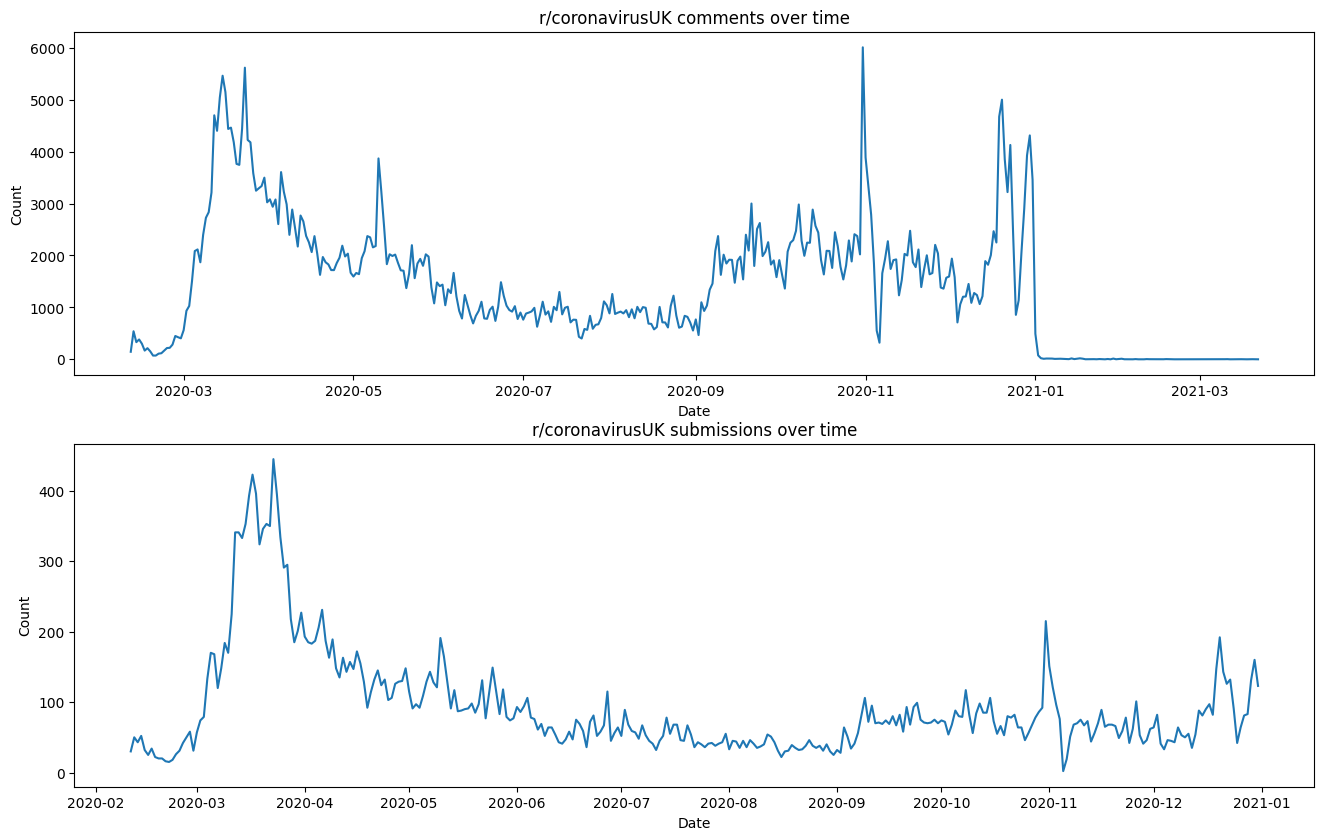

In [3]:
### PLOTTING COMMENTS AND SUBMISSIONS ON r/coronavirusUK OVER TIME

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

comments = c_df['datetime'].dt.date.value_counts()
submissions = s_df['datetime'].dt.date.value_counts()

submissions = submissions.sort_index(ascending=True)
comments = comments.sort_index(ascending=True)

fig, (ax1, ax2) = plt.subplots(2, dpi=100)
fig.set_size_inches(16, 10)

ax1.set_title('r/coronavirusUK comments over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Count')
ax1.plot(comments.index, comments.values)

ax2.set_title('r/coronavirusUK submissions over time')
ax2.set_xlabel('Date')
ax2.set_ylabel('Count')
ax2.plot(submissions.index, submissions.values)

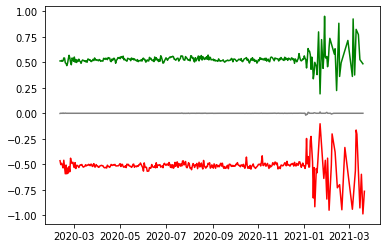

In [4]:
### PLOTTING MEAN SENTIMENT OF ALL COMMENTS PER DAY OVER TIME

c_df = c_df.sort_values(by='datetime')

positive_data = c_df.query(
    'sentiment == "positive"'
).groupby(
    c_df['datetime'].dt.date
).agg(
    {
        'compound_score': mean
    }
)

neutral_data = c_df.query(
    'sentiment == "neutral"'
).groupby(
    c_df['datetime'].dt.date
).agg(
    {
        'compound_score': mean
    }
)

negative_data = c_df.query(
    'sentiment == "negative"'
).groupby(
    c_df['datetime'].dt.date
).agg(
    {
        'compound_score': mean
    }
)

plt.plot(positive_data, 'g-')
plt.plot(neutral_data, '#808080')
plt.plot(negative_data, 'r-')

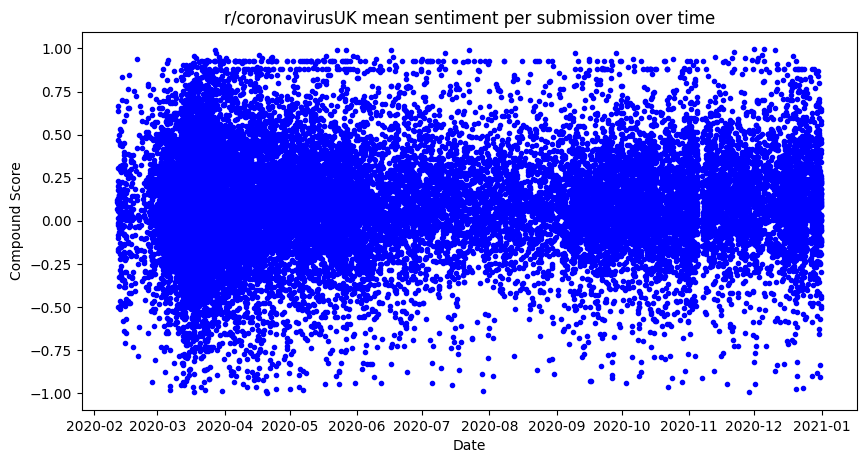

In [5]:
### PLOTTING NON-NEUTRAL COMMENTS BY SUBMISSION ON r/coronavirusUK OVER TIME

s_df = s_df.sort_values(by='datetime')
c_df = c_df.sort_values(by='datetime')

### SUBMISSION COMPOUND SCORE CALCULATED BY MEAN OF COMMENTS FROM EACH SUBMISSION
agg_sub_compound_score = c_df.query(
    'sentiment != "neutral"'
).groupby(
    c_df['submission_id']
).agg(
    {
        'compound_score': mean
    }
)

sub_comments = pd.merge(s_df, agg_sub_compound_score, left_index=True, right_index=True)

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('r/coronavirusUK mean sentiment per submission over time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Compound Score')
ax1.plot(sub_comments['datetime'], sub_comments['compound_score'], 'b.')

In [6]:
### TRANSFORMS COMMENT DATAFRAME INTO DICTIONARY TO BE VECTORIZED

df_to_dict = c_df.copy().query('sentiment != "neutral"').reset_index()
df_to_dict['target'] = df_to_dict.apply(lambda x: get_target(x['sentiment']), axis=1)
df_to_dict = df_to_dict.drop(columns=['datetime', 'sentiment', 'compound_score', 'submission_id', 'parent_id'])
df_dict = {'body': list(df_to_dict['body']), 'target': list(df_to_dict['target'])}

In [19]:
x

range(0, 25)

<BarContainer object of 25 artists>

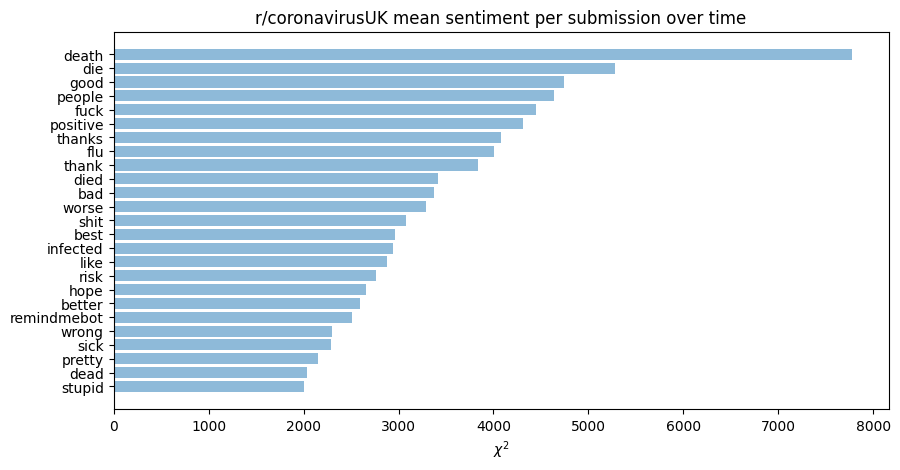

In [51]:
### RETURNS THE TOP N TERMS
topchi2 = document_vectorizer(df_dict, 25)

x = range(len(topchi2[1]))
labels = topchi2[0]

fig, ax1 = plt.subplots(1, dpi=100)
fig.set_size_inches(10, 5)

ax1.set_title('Chi2 score for terms with positive and negative sentiment')
ax1.set_xlabel('$\chi^2$')
ax1.set_yticks(x)
ax1.set_yticklabels(labels)
ax1.barh(x, topchi2[1], align='center', alpha=0.5)

In [ ]:
### LATENT DIRICHLET ALLOCATION (LDA)

import re

# Remove punctuation



In [ ]:
c_df.sample(10)

In [ ]:
s_df.sample(5)